### Set-up

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
!cd /content/drive/MyDrive/Mantises!/

Mounted at /content/drive


In [17]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import ast
import numpy as np
import os
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

### Create main table structure

In [3]:
counties_shapefile = '/content/drive/My Drive/Mantises!/data/gadm41_USA_shp/gadm41_USA_2.shp'
counties = gpd.read_file(counties_shapefile)

# Filter to include only counties in California
california_counties = counties[counties['NAME_1'] == 'California']
merged_table1 = pd.DataFrame(california_counties['NAME_2'].unique(), columns=['County'])


merged_table1.head()


,County
0,Alameda
1,Alpine
2,Amador
3,Butte
4,Calaveras


### Join with ecoregion data

In [4]:
# Load the ecoregion data
ecoregion_data_path = '/content/drive/My Drive/Mantises!/output/ecoregions_per_county.csv'
ecoregion_data = pd.read_csv(ecoregion_data_path)

unique_ecoregions = set()
for ecoregions_str in ecoregion_data['Unique_Ecoregions']:
    ecoregions = ast.literal_eval(ecoregions_str)
    unique_ecoregions.update(ecoregions)

# Convert the 'Unique_Ecoregions' column in ecoregion_data to actual sets
ecoregion_data['Unique_Ecoregions'] = ecoregion_data['Unique_Ecoregions'].apply(ast.literal_eval)

# Create a dictionary mapping counties to their ecoregions
county_ecoregion_map = ecoregion_data.set_index('County')['Unique_Ecoregions'].to_dict()

# Add binary columns for each ecoregion
for ecoregion in unique_ecoregions:
    merged_table1['Eco_' + ecoregion.replace(' ', '_')] = merged_table1['County'].map(
        lambda county: ecoregion in county_ecoregion_map.get(county, set())
    )

merged_table1.head()

,County,Eco_Central_Basin_and_Range,Eco_Mojave_Basin_and_Range,Eco_Sierra_Nevada,Eco_Central_California_Valley,Eco_Southern_California_Mountains,Eco_Southern_California/Northern_Baja_Coast,Eco_Northern_Basin_and_Range,Eco_Eastern_Cascades_Slopes_and_Foothills,Eco_Cascades,Eco_Sonoran_Basin_and_Range,Eco_Central_California_Foothills_and_Coastal_Mountains,Eco_Coast_Range,Eco_Klamath_Mountains/California_High_North_Coast_Range
0,Alameda,False,False,False,True,False,False,False,False,False,False,True,False,False
1,Alpine,True,False,True,False,False,False,False,False,False,False,False,False,False
2,Amador,False,False,True,False,False,False,False,False,False,False,True,False,False
3,Butte,False,False,True,True,False,False,False,False,True,False,True,False,False
4,Calaveras,False,False,True,False,False,False,False,False,False,False,True,False,False


### Join with human population data

In [5]:
# Load the human population data
human_population_data_path = '/content/drive/My Drive/Mantises!/output/human_population_per_county.csv'
human_population_data = pd.read_csv(human_population_data_path)
human_population_data = human_population_data.rename(columns={'NAME_2': 'County'})
human_population_data = human_population_data[['County', 'population_total']]

# Merge
merged_table2 = pd.merge(merged_table1, human_population_data, on='County', how='left')

merged_table2.head()


,County,Eco_Central_Basin_and_Range,Eco_Mojave_Basin_and_Range,Eco_Sierra_Nevada,Eco_Central_California_Valley,Eco_Southern_California_Mountains,Eco_Southern_California/Northern_Baja_Coast,Eco_Northern_Basin_and_Range,Eco_Eastern_Cascades_Slopes_and_Foothills,Eco_Cascades,Eco_Sonoran_Basin_and_Range,Eco_Central_California_Foothills_and_Coastal_Mountains,Eco_Coast_Range,Eco_Klamath_Mountains/California_High_North_Coast_Range,population_total
0,Alameda,False,False,False,True,False,False,False,False,False,False,True,False,False,1661584
1,Alpine,True,False,True,False,False,False,False,False,False,False,False,False,False,1159
2,Amador,False,False,True,False,False,False,False,False,False,False,True,False,False,39023
3,Butte,False,False,True,True,False,False,False,False,True,False,True,False,False,223344
4,Calaveras,False,False,True,False,False,False,False,False,False,False,True,False,False,45828


### Join table with climatic data

In [11]:
# Load the climate data
climate_data_path = '/content/drive/My Drive/Mantises!/output/climatic_data/climatic_data_20231206_050035.csv'
climate_data = pd.read_csv(climate_data_path)
climate_data = climate_data.drop(columns=['State'])
climate_data_per_county = climate_data.groupby('County').agg({'tmax': 'mean', 'tmin': 'mean', 'prcp': 'mean'}).reset_index()


# Merge
merged_table3 = pd.merge(merged_table2, climate_data_per_county, on='County', how='left')

merged_table3.head()


,County,Eco_Central_Basin_and_Range,Eco_Mojave_Basin_and_Range,Eco_Sierra_Nevada,Eco_Central_California_Valley,Eco_Southern_California_Mountains,Eco_Southern_California/Northern_Baja_Coast,Eco_Northern_Basin_and_Range,Eco_Eastern_Cascades_Slopes_and_Foothills,Eco_Cascades,Eco_Sonoran_Basin_and_Range,Eco_Central_California_Foothills_and_Coastal_Mountains,Eco_Coast_Range,Eco_Klamath_Mountains/California_High_North_Coast_Range,population_total,tmax,tmin,prcp
0,Alameda,False,False,False,True,False,False,False,False,False,False,True,False,False,1661584,20.904928,9.695275,40.319967
1,Alpine,True,False,True,False,False,False,False,False,False,False,False,False,False,1159,12.457218,-0.429198,81.807864
2,Amador,False,False,True,False,False,False,False,False,False,False,True,False,False,39023,20.845305,7.341989,80.838894
3,Butte,False,False,True,True,False,False,False,False,True,False,True,False,False,223344,22.181397,8.452543,96.290673
4,Calaveras,False,False,True,False,False,False,False,False,False,False,True,False,False,45828,21.392718,7.554954,78.762067


### Join county and biodiversity data



In [12]:
biodiversity_data = pd.read_csv(f'/content/drive/My Drive/Mantises!/data/mantodea_ca_gbif_simple.csv', sep='\t')

status = {
    'Mantis religiosa': 'introduced',
    'Stagmomantis californica': 'native',
    'Litaneutria pacifica': 'native',
    'Litaneutria skinneri': 'native',
    'Stagmomantis limbata': 'native',
    'Iris oratoria': 'introduced',
    'Miomantis caffra': 'introduced',
    'Litaneutria ocularis': 'native',
    'Tenodera sinensis': 'introduced',
    'Litaneutria chaparrali': 'native',
    'Hierodula patellifera': 'introduced',
    'Litaneutria minor': 'native',
    'Yersiniops newboldi': 'native',
    'Thesprotia graminis': 'native'
}

# Add status column
biodiversity_data['status'] = biodiversity_data['species'].map(status)

unique_species = biodiversity_data['species'].unique()
unique_species = [species for species in unique_species if not pd.isna(species)]

biodiversity_data.head()

,gbifID,datasetKey,occurrenceID,kingdom,phylum,class,order,family,genus,species,...,dateIdentified,license,rightsHolder,recordedBy,typeStatus,establishmentMeans,lastInterpreted,mediaType,issue,status
0,923926829,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/766957,Animalia,Arthropoda,Insecta,Mantodea,Mantidae,Mantis,Mantis religiosa,...,2014-07-03T20:54:23,CC_BY_NC_4_0,Callahan Charleton,Callahan Charleton,NaN,NaN,2023-09-28T11:04:15.229Z,StillImage,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_MATCH...,introduced
1,923921190,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/750035,Animalia,Arthropoda,Insecta,Mantodea,Mantidae,Mantis,Mantis religiosa,...,2014-06-23T01:27:47,CC0_1_0,Tony Iwane,Tony Iwane,NaN,NaN,2023-09-28T12:35:45.908Z,StillImage,COORDINATE_ROUNDED;CONTINENT_DERIVED_FROM_COOR...,introduced
2,923917961,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/741586,Animalia,Arthropoda,Insecta,Mantodea,Mantidae,Mantis,Mantis religiosa,...,2014-06-18T17:43:13,CC_BY_NC_4_0,Todd Plummer,Todd Plummer,NaN,NaN,2023-09-28T11:04:17.149Z,StillImage,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_MATCH...,introduced
3,899975780,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/645036,Animalia,Arthropoda,Insecta,Mantodea,Mantidae,Mantis,Mantis religiosa,...,2014-04-27T06:25:51,CC_BY_NC_4_0,Eric Jacob,Eric Jacob,NaN,NaN,2023-09-28T12:34:59.254Z,StillImage,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_MATCH...,introduced
4,891755288,50c9509d-22c7-4a22-a47d-8c48425ef4a7,http://www.inaturalist.org/observations/439613,Animalia,Arthropoda,Insecta,Mantodea,Mantidae,Mantis,Mantis religiosa,...,2013-10-25T04:13:21,CC_BY_NC_4_0,Paul G. Johnson,Paul G. Johnson,NaN,NaN,2023-09-28T11:04:05.380Z,StillImage,CONTINENT_DERIVED_FROM_COORDINATES;TAXON_MATCH...,introduced


In [13]:
# Load the shapefile with US counties
counties_shapefile = '/content/drive/My Drive/Mantises!/data/gadm41_USA_shp/gadm41_USA_2.shp'
counties = gpd.read_file(counties_shapefile)

# Convert the biodiversity data into a GeoDataFrame
geometry = [Point(xy) for xy in zip(biodiversity_data['decimalLongitude'], biodiversity_data['decimalLatitude'])]
biodiversity_gdf = gpd.GeoDataFrame(biodiversity_data, geometry=geometry)
biodiversity_gdf.set_crs(counties.crs, inplace=True)

# Spatial join to find which county each point falls into
joined = gpd.sjoin(biodiversity_gdf, counties, how='inner', predicate='within')

# Aggregate data to count occurrences per species, status, and county
biodiv_per_county = joined.groupby(['species', 'status', 'NAME_2']).size().reset_index(name='count')
biodiv_per_county = biodiv_per_county.rename(columns={'NAME_2': 'County'})

biodiv_per_county.head()

,species,status,County,count
0,Hierodula patellifera,introduced,Alameda,1
1,Iris oratoria,introduced,Alameda,1
2,Iris oratoria,introduced,Butte,16
3,Iris oratoria,introduced,Contra Costa,11
4,Iris oratoria,introduced,Fresno,11


In [14]:
# Initialize columns for each species
for species in unique_species:
    merged_table3[species] = 0

# Update the species column values
for index, row in biodiv_per_county.iterrows():
    species = row['species']
    county = row['County']
    count = row['count']

    if count > 0:
        # Update the species column for the county to 1 (presence)
        merged_table3.loc[merged_table3['County'] == county, species] = 1

# Display the updated merged_table
merged_table3.head()

,County,Eco_Central_Basin_and_Range,Eco_Mojave_Basin_and_Range,Eco_Sierra_Nevada,Eco_Central_California_Valley,Eco_Southern_California_Mountains,Eco_Southern_California/Northern_Baja_Coast,Eco_Northern_Basin_and_Range,Eco_Eastern_Cascades_Slopes_and_Foothills,Eco_Cascades,...,Stagmomantis limbata,Iris oratoria,Miomantis caffra,Litaneutria ocularis,Tenodera sinensis,Litaneutria chaparrali,Hierodula patellifera,Litaneutria minor,Yersiniops newboldi,Thesprotia graminis
0,Alameda,False,False,False,True,False,False,False,False,False,...,1,1,0,1,1,0,1,0,0,0
1,Alpine,True,False,True,False,False,False,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,Amador,False,False,True,False,False,False,False,False,False,...,1,0,0,0,0,0,0,0,0,0
3,Butte,False,False,True,True,False,False,False,False,True,...,1,1,0,1,0,0,0,0,0,0
4,Calaveras,False,False,True,False,False,False,False,False,False,...,1,0,0,0,0,0,0,0,0,0


### Decision trees per species

In [21]:
# Define ecoregion columns based on unique_ecoregions set
ecoregion_columns = ['Eco_' + ecoregion.replace(' ', '_') for ecoregion in unique_ecoregions]

# Define columns to include based on unique_ecoregions set and additional parameters
columns_to_include = ['tmax', 'tmin', 'prcp', 'population_total'] + ecoregion_columns

# Prepare a DataFrame to store metrics for each species
metrics_df = pd.DataFrame(columns=['Species', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Output directory for decision tree visualizations
output_dir = '/content/drive/My Drive/Mantises!/output/decision_trees'
os.makedirs(output_dir, exist_ok=True)

# Iterate over each species to build a model and visualize the decision tree
for species in unique_species:
    # Prepare features (X) and target variable (y)
    X = merged_table3[columns_to_include]
    y = merged_table3[species]

    # Check if there's enough data to train the model
    if y.nunique() <= 1:
        print(f"Skipping model for {species}: insufficient variation in target variable.")
        continue

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the decision tree classifier
    model = DecisionTreeClassifier(criterion='entropy', random_state=42)
    model.fit(X_train, y_train)

    # Visualize the decision tree
    plt.figure(figsize=(20, 10))
    plot_tree(model, feature_names=columns_to_include, class_names=['Absent', 'Present'], filled=True)
    plt.title(f"Decision Tree for {species}")

    # Save the figure
    plt.savefig(os.path.join(output_dir, f"decision_tree_{species}.png"))
    plt.close()

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')

    # Append metrics to the DataFrame
    metrics_df = metrics_df.append({
        'Species': species,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }, ignore_index=True)

    # Extract and print feature importances
    feature_importances = model.feature_importances_
    importance_df = pd.DataFrame(feature_importances, index=columns_to_include, columns=['Importance']).sort_values(by='Importance', ascending=False)
    print(f"Feature Importances for {species}:\n", importance_df)
    print("\n")

# Export the metrics to CSV
metrics_csv_path = '/content/drive/My Drive/Mantises!/output/decision_trees/species_decision_tree_metrics.csv'
metrics_df.to_csv(metrics_csv_path, index=False)

metrics_df.head()


<ipython-input-21-b3340c3f531a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


Feature Importances for Mantis religiosa:
                                                     Importance
tmin                                                  0.387234
population_total                                      0.356687
tmax                                                  0.256080
Eco_Northern_Basin_and_Range                          0.000000
Eco_Coast_Range                                       0.000000
Eco_Central_California_Foothills_and_Coastal_Mo...    0.000000
Eco_Sonoran_Basin_and_Range                           0.000000
Eco_Cascades                                          0.000000
Eco_Eastern_Cascades_Slopes_and_Foothills             0.000000
Eco_Southern_California_Mountains                     0.000000
Eco_Southern_California/Northern_Baja_Coast           0.000000
Eco_Central_California_Valley                         0.000000
Eco_Sierra_Nevada                                     0.000000
Eco_Mojave_Basin_and_Range                            0.000000
Eco_Central_

<ipython-input-21-b3340c3f531a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


Feature Importances for Stagmomantis californica:
                                                     Importance
prcp                                                  0.625928
population_total                                      0.177252
Eco_Southern_California/Northern_Baja_Coast           0.071474
Eco_Central_California_Foothills_and_Coastal_Mo...    0.063326
tmin                                                  0.062020
tmax                                                  0.000000
Eco_Eastern_Cascades_Slopes_and_Foothills             0.000000
Eco_Coast_Range                                       0.000000
Eco_Sonoran_Basin_and_Range                           0.000000
Eco_Cascades                                          0.000000
Eco_Southern_California_Mountains                     0.000000
Eco_Northern_Basin_and_Range                          0.000000
Eco_Central_California_Valley                         0.000000
Eco_Sierra_Nevada                                     0.000000
Eco_

<ipython-input-21-b3340c3f531a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


Feature Importances for Litaneutria pacifica:
                                                     Importance
population_total                                      0.561767
tmin                                                  0.234774
tmax                                                  0.144700
prcp                                                  0.058759
Eco_Northern_Basin_and_Range                          0.000000
Eco_Coast_Range                                       0.000000
Eco_Central_California_Foothills_and_Coastal_Mo...    0.000000
Eco_Sonoran_Basin_and_Range                           0.000000
Eco_Cascades                                          0.000000
Eco_Eastern_Cascades_Slopes_and_Foothills             0.000000
Eco_Southern_California_Mountains                     0.000000
Eco_Southern_California/Northern_Baja_Coast           0.000000
Eco_Central_California_Valley                         0.000000
Eco_Sierra_Nevada                                     0.000000
Eco_Moja

<ipython-input-21-b3340c3f531a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


Feature Importances for Litaneutria skinneri:
                                                     Importance
population_total                                      0.662984
tmin                                                  0.337016
tmax                                                  0.000000
Eco_Northern_Basin_and_Range                          0.000000
Eco_Coast_Range                                       0.000000
Eco_Central_California_Foothills_and_Coastal_Mo...    0.000000
Eco_Sonoran_Basin_and_Range                           0.000000
Eco_Cascades                                          0.000000
Eco_Eastern_Cascades_Slopes_and_Foothills             0.000000
Eco_Southern_California_Mountains                     0.000000
Eco_Southern_California/Northern_Baja_Coast           0.000000
Eco_Central_California_Valley                         0.000000
Eco_Sierra_Nevada                                     0.000000
Eco_Mojave_Basin_and_Range                            0.000000
Eco_Cent

<ipython-input-21-b3340c3f531a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


Feature Importances for Stagmomantis limbata:
                                                     Importance
tmax                                                  0.427559
Eco_Klamath_Mountains/California_High_North_Coa...    0.212106
population_total                                      0.122593
Eco_Sierra_Nevada                                     0.086952
Eco_Coast_Range                                       0.069721
tmin                                                  0.059436
prcp                                                  0.021632
Eco_Central_Basin_and_Range                           0.000000
Eco_Mojave_Basin_and_Range                            0.000000
Eco_Central_California_Valley                         0.000000
Eco_Southern_California/Northern_Baja_Coast           0.000000
Eco_Northern_Basin_and_Range                          0.000000
Eco_Eastern_Cascades_Slopes_and_Foothills             0.000000
Eco_Cascades                                          0.000000
Eco_Sono

<ipython-input-21-b3340c3f531a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


Feature Importances for Iris oratoria:
                                                     Importance
tmax                                                  0.344113
population_total                                      0.300143
Eco_Central_California_Valley                         0.235803
Eco_Central_California_Foothills_and_Coastal_Mo...    0.059971
tmin                                                  0.059971
Eco_Northern_Basin_and_Range                          0.000000
Eco_Coast_Range                                       0.000000
Eco_Sonoran_Basin_and_Range                           0.000000
Eco_Cascades                                          0.000000
Eco_Eastern_Cascades_Slopes_and_Foothills             0.000000
Eco_Southern_California_Mountains                     0.000000
Eco_Southern_California/Northern_Baja_Coast           0.000000
Eco_Sierra_Nevada                                     0.000000
Eco_Mojave_Basin_and_Range                            0.000000
Eco_Central_Bas

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
<ipython-input-21-b3340c3f531a>:51: FutureWarning: The frame.append method is deprecated and will be removed fr

Feature Importances for Miomantis caffra:
                                                     Importance
population_total                                      0.569638
tmin                                                  0.258864
tmax                                                  0.171498
Eco_Northern_Basin_and_Range                          0.000000
Eco_Coast_Range                                       0.000000
Eco_Central_California_Foothills_and_Coastal_Mo...    0.000000
Eco_Sonoran_Basin_and_Range                           0.000000
Eco_Cascades                                          0.000000
Eco_Eastern_Cascades_Slopes_and_Foothills             0.000000
Eco_Southern_California_Mountains                     0.000000
Eco_Southern_California/Northern_Baja_Coast           0.000000
Eco_Central_California_Valley                         0.000000
Eco_Sierra_Nevada                                     0.000000
Eco_Mojave_Basin_and_Range                            0.000000
Eco_Central_

<ipython-input-21-b3340c3f531a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


Feature Importances for Litaneutria ocularis:
                                                     Importance
population_total                                      0.508015
tmin                                                  0.223742
prcp                                                  0.137264
tmax                                                  0.130979
Eco_Northern_Basin_and_Range                          0.000000
Eco_Coast_Range                                       0.000000
Eco_Central_California_Foothills_and_Coastal_Mo...    0.000000
Eco_Sonoran_Basin_and_Range                           0.000000
Eco_Cascades                                          0.000000
Eco_Eastern_Cascades_Slopes_and_Foothills             0.000000
Eco_Southern_California_Mountains                     0.000000
Eco_Southern_California/Northern_Baja_Coast           0.000000
Eco_Central_California_Valley                         0.000000
Eco_Sierra_Nevada                                     0.000000
Eco_Moja

<ipython-input-21-b3340c3f531a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


Feature Importances for Tenodera sinensis:
                                                     Importance
prcp                                                  0.462612
population_total                                      0.240309
Eco_Central_California_Valley                         0.239521
tmax                                                  0.057558
Eco_Northern_Basin_and_Range                          0.000000
Eco_Coast_Range                                       0.000000
Eco_Central_California_Foothills_and_Coastal_Mo...    0.000000
Eco_Sonoran_Basin_and_Range                           0.000000
Eco_Cascades                                          0.000000
Eco_Eastern_Cascades_Slopes_and_Foothills             0.000000
Eco_Southern_California_Mountains                     0.000000
Eco_Southern_California/Northern_Baja_Coast           0.000000
tmin                                                  0.000000
Eco_Sierra_Nevada                                     0.000000
Eco_Mojave_

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-21-b3340c3f531a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


Feature Importances for Litaneutria chaparrali:
                                                     Importance
tmin                                                       1.0
tmax                                                       0.0
Eco_Southern_California/Northern_Baja_Coast                0.0
Eco_Coast_Range                                            0.0
Eco_Central_California_Foothills_and_Coastal_Mo...         0.0
Eco_Sonoran_Basin_and_Range                                0.0
Eco_Cascades                                               0.0
Eco_Eastern_Cascades_Slopes_and_Foothills                  0.0
Eco_Northern_Basin_and_Range                               0.0
Eco_Southern_California_Mountains                          0.0
Eco_Central_California_Valley                              0.0
Eco_Sierra_Nevada                                          0.0
Eco_Mojave_Basin_and_Range                                 0.0
Eco_Central_Basin_and_Range                                0.0
popula

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-21-b3340c3f531a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


Feature Importances for Hierodula patellifera:
                                                     Importance
tmax                                                       0.0
Eco_Southern_California/Northern_Baja_Coast                0.0
Eco_Coast_Range                                            0.0
Eco_Central_California_Foothills_and_Coastal_Mo...         0.0
Eco_Sonoran_Basin_and_Range                                0.0
Eco_Cascades                                               0.0
Eco_Eastern_Cascades_Slopes_and_Foothills                  0.0
Eco_Northern_Basin_and_Range                               0.0
Eco_Southern_California_Mountains                          0.0
tmin                                                       0.0
Eco_Central_California_Valley                              0.0
Eco_Sierra_Nevada                                          0.0
Eco_Mojave_Basin_and_Range                                 0.0
Eco_Central_Basin_and_Range                                0.0
populat

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-21-b3340c3f531a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


Feature Importances for Litaneutria minor:
                                                     Importance
Eco_Southern_California/Northern_Baja_Coast           0.403625
tmin                                                  0.286311
tmax                                                  0.158216
population_total                                      0.151847
Eco_Northern_Basin_and_Range                          0.000000
Eco_Coast_Range                                       0.000000
Eco_Central_California_Foothills_and_Coastal_Mo...    0.000000
Eco_Sonoran_Basin_and_Range                           0.000000
Eco_Cascades                                          0.000000
Eco_Eastern_Cascades_Slopes_and_Foothills             0.000000
Eco_Southern_California_Mountains                     0.000000
Eco_Central_California_Valley                         0.000000
Eco_Sierra_Nevada                                     0.000000
Eco_Mojave_Basin_and_Range                            0.000000
Eco_Central

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
<ipython-input-21-b3340c3f531a>:51: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append({


Feature Importances for Yersiniops newboldi:
                                                     Importance
tmax                                                  0.776444
tmin                                                  0.223556
Eco_Southern_California/Northern_Baja_Coast           0.000000
Eco_Coast_Range                                       0.000000
Eco_Central_California_Foothills_and_Coastal_Mo...    0.000000
Eco_Sonoran_Basin_and_Range                           0.000000
Eco_Cascades                                          0.000000
Eco_Eastern_Cascades_Slopes_and_Foothills             0.000000
Eco_Northern_Basin_and_Range                          0.000000
Eco_Southern_California_Mountains                     0.000000
Eco_Central_California_Valley                         0.000000
Eco_Sierra_Nevada                                     0.000000
Eco_Mojave_Basin_and_Range                            0.000000
Eco_Central_Basin_and_Range                           0.000000
populatio

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
<ipython-input-21-b3340c3f531a>:51: FutureWarning: The frame.append method is deprecated and will be removed fr

,Species,Accuracy,Precision,Recall,F1 Score
0,Mantis religiosa,1.000000,1.000000,1.000000,1.000000
1,Stagmomantis californica,0.250000,0.142857,0.250000,0.181818
2,Litaneutria pacifica,0.583333,0.666667,0.333333,0.444444
3,Litaneutria skinneri,0.833333,0.500000,0.500000,0.500000
4,Stagmomantis limbata,0.500000,0.500000,0.666667,0.571429


In [35]:

# Load the metrics data
metrics_df = pd.read_csv('/content/drive/My Drive/Mantises!/output/decision_trees/species_decision_tree_metrics.csv')

# Calculate the count of each species in the biodiversity data
species_counts = biodiversity_data['species'].value_counts()

# Convert counts to DataFrame
species_counts_df = species_counts.reset_index()
species_counts_df.columns = ['Species', 'Count']

# Add 'status' to metrics_df
metrics_df['Status'] = metrics_df['Species'].map(status)

# Merge the metrics_df with the species counts
merged_df = pd.merge(metrics_df, species_counts_df, on='Species', how='left')
merged_df = merged_df.sort_values(by=['Status', 'Count', 'Species'], ascending=[False, True, False])

merged_df


,Species,Accuracy,Precision,Recall,F1 Score,Status,Count
13,Thesprotia graminis,1.000000,0.000000,0.000000,0.000000,native,1
9,Litaneutria chaparrali,0.916667,0.000000,0.000000,0.000000,native,2
12,Yersiniops newboldi,0.916667,0.000000,0.000000,0.000000,native,3
3,Litaneutria skinneri,0.833333,0.500000,0.500000,0.500000,native,4
11,Litaneutria minor,0.833333,0.000000,0.000000,0.000000,native,7
7,Litaneutria ocularis,0.750000,1.000000,0.400000,0.571429,native,54
2,Litaneutria pacifica,0.583333,0.666667,0.333333,0.444444,native,102
1,Stagmomantis californica,0.250000,0.142857,0.250000,0.181818,native,336
4,Stagmomantis limbata,0.500000,0.500000,0.666667,0.571429,native,1713
10,Hierodula patellifera,0.916667,0.000000,0.000000,0.000000,introduced,1


### Litaneutria skinneri analysis

In [42]:
# Model worked best for Litaneutria skinneri, so here are the counties we can find it in

filtered_counties = merged_table3[(merged_table3['population_total'] < 18081.5) & (merged_table3['tmin'] > 1.304)]
filtered_counties = filtered_counties[['County', 'Litaneutria skinneri']]

filtered_counties



,County,Litaneutria skinneri
13,Inyo,1
21,Mariposa,1
45,Sierra,1
52,Trinity,0


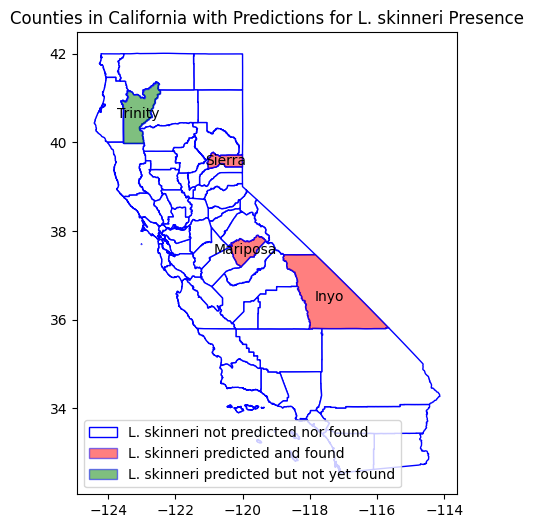

In [50]:
# Create new column in california_counties for the count of Litaneutria skinneri
california_counties['Litaneutria_skinneri'] = 0

# Update the counts from the filtered_counties DataFrame
for index, row in filtered_counties.iterrows():
    county_name = row['County']
    county_count = row['Litaneutria skinneri']
    california_counties.loc[california_counties['NAME_2'] == county_name, 'Litaneutria_skinneri'] = county_count

# Define colors for legend
legend_colors = {'L. skinneri not predicted nor found': 'white',
                 'L. skinneri predicted and found': 'red',
                 'L. skinneri predicted but not yet found': 'green'}

# Plot counties not in filtered_counties
base = california_counties.plot(figsize=(12, 6), color=legend_colors['L. skinneri not predicted nor found'], edgecolor='blue')

# Overlay counties where L. skinneri is predicted and found
california_counties[(california_counties['Litaneutria_skinneri'] > 0)].plot(ax=base, color=legend_colors['L. skinneri predicted and found'], alpha=0.5, edgecolor='blue')

# Overlay counties where L. skinneri is predicted but not yet found
california_counties[(california_counties['Litaneutria_skinneri'] == 0) & (california_counties['IsFiltered'])].plot(ax=base, color=legend_colors['L. skinneri predicted but not yet found'], alpha=0.5, edgecolor='blue')

# Annotate the names of the filtered counties
for _, row in california_counties[california_counties['IsFiltered']].iterrows():
    plt.annotate(text=row['NAME_2'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', verticalalignment='center', color='black')

# Create legend
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor=legend_colors[key], edgecolor='blue', label=key, alpha=0.5 if key != 'L. skinneri not predicted nor found' else 1) for key in legend_colors]
plt.legend(handles=legend_patches, loc='lower left')
plt.title('Counties in California with Predictions for L. skinneri Presence')

plt.show()


### Decision trees for introduced/native

In [18]:
# Aggregate environmental data for each species, including ecoregions
species_data = pd.DataFrame(index=unique_species)
for species in unique_species:
    species_rows = merged_table3[merged_table3[species] == 1]  # Rows where the species is present
    for col in ['tmax', 'tmin', 'prcp', 'population_total'] + ecoregion_columns:
        # Mean for continuous variables, mode (most common value) for ecoregions
        if col in ecoregion_columns:
            species_data.at[species, col] = species_rows[col].mode()[0]
        else:
            species_data.at[species, col] = species_rows[col].mean()

# Add species status
species_data['status'] = [1 if status[species] == 'introduced' else 0 for species in species_data.index]

# Split data into features (X) and target (y)
X = species_data.drop(columns=['status'])
y = species_data['status']

# Decision Tree Model
model = DecisionTreeClassifier(criterion='entropy', random_state=42)
model.fit(X, y)

# Cross-validation
scoring = {'accuracy': 'accuracy',
           'precision': make_scorer(precision_score, zero_division=0),
           'recall': make_scorer(recall_score, zero_division=0),
           'f1': make_scorer(f1_score, zero_division=0)}

cv_results = cross_validate(model, X, y, cv=5, scoring=scoring)

# Average across folds
metrics_avg = {metric: np.mean(cv_results['test_' + metric]) for metric in scoring.keys()}

print("Cross-validated metrics:")
print(metrics_avg)

# Save metrics to CSV
output_dir = '/content/drive/My Drive/Mantises!/output/decision_trees'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
metrics_csv_path = os.path.join(output_dir, 'introduced_native_decision_tree_metrics.csv')
pd.DataFrame([metrics_avg]).to_csv(metrics_csv_path, index=False)

# Decision Tree Visualization
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, class_names=['Native', 'Introduced'], filled=True)
plt.title("Decision Tree for Species Status Prediction")
plt.savefig(os.path.join(output_dir, 'introduced_native_decision_tree.png'))
plt.close()

print(f"Metrics saved to: {metrics_csv_path}")


Cross-validated metrics:
{'accuracy': 0.4333333333333333, 'precision': 0.1, 'recall': 0.2, 'f1': 0.13333333333333333}
Metrics saved to: /content/drive/My Drive/Mantises!/output/decision_trees/introduced_native_decision_tree_metrics.csv
